In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/HarpyTech/DSAI-MTech/refs/heads/main/TSF/Sun_Spots/train.csv")
data.Month = pd.to_datetime(data.Month, format="%m-%d-%Y")
data.set_index("Month", inplace=True)
data.head()

,Avg_sunspot_count
Month,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142


<Axes: xlabel='Month'>

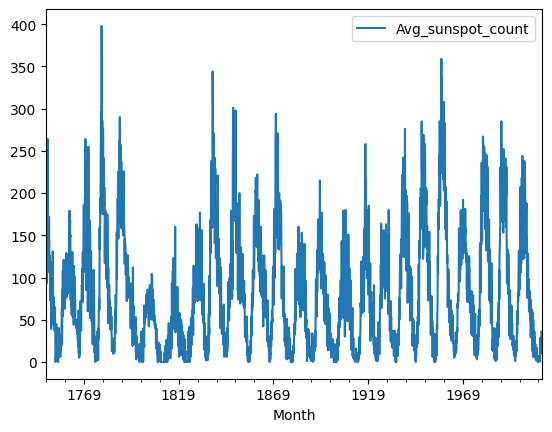

In [3]:
data.plot.line()

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Split the Data set into 80:20
train = data.iloc[:int(len(data)*0.8)//1]
test = data.iloc[int(len(data)*0.8)//1:]
train.shape, test.shape , int(len(data)*0.8)//1

((2515, 1), (629, 1), 2515)

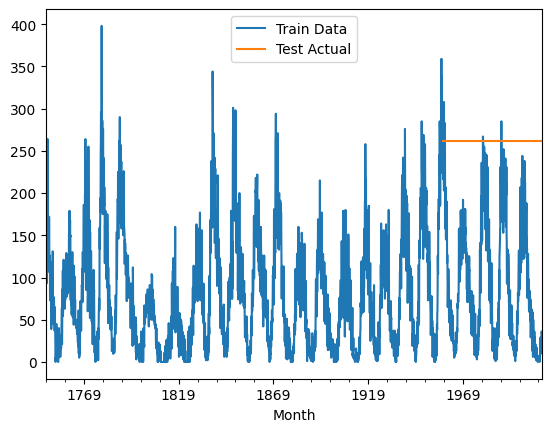

In [15]:
model_ses = SimpleExpSmoothing(train,
                               initialization_method='estimated')
model_ses_autofit = model_ses.fit(optimized=True)
ts_test_pred = model_ses_autofit.forecast(steps=len(test))
ts_test_pred.index = test.index

data.plot.line()
ts_test_pred.plot.line();
plt.legend(['Train Data', 'Test Actual', 'Test Predicted']);

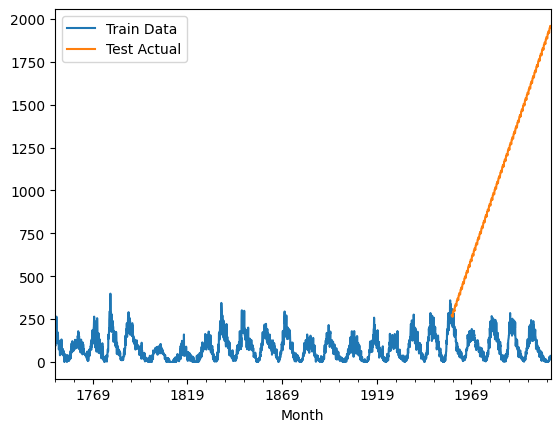

In [16]:
model_holt_winter = ExponentialSmoothing(
    train,
    trend='additive',
    seasonal='additive',
    initialization_method='estimated')
model_holt_winter_fitted = model_holt_winter.fit(optimized=True)
ts_test_pred_e = model_holt_winter_fitted.forecast(steps=len(test))

data.plot.line()
ts_test_pred_e.plot.line();
plt.legend(['Train Data', 'Test Actual', 'Test Predicted']);

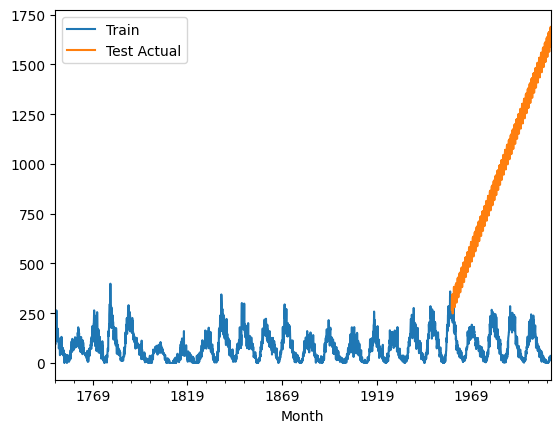

In [14]:
model = ARIMA(train,
              order=(1,1,0),
              seasonal_order=(1, 1, 0, 12),
              )
model_fit = model.fit()
model_fit.summary()

ts_test_pred = model_fit.get_forecast(steps=120).predicted_mean


data.plot.line()
ts_test_pred.plot.line()
plt.legend(['Train', 'Test Actual', 'Test Pred']);

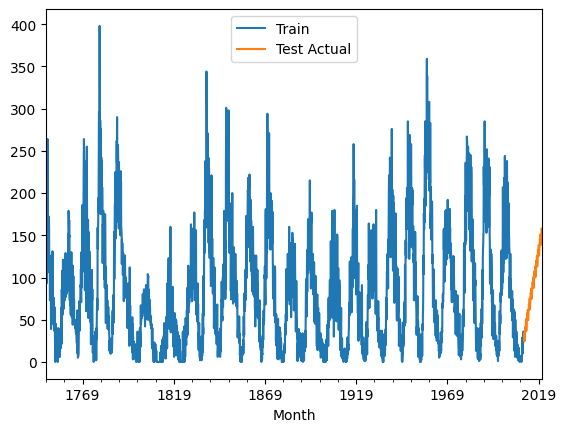

In [13]:
model = ARIMA(data,
              order=(1,1,0),
              seasonal_order=(1, 1, 0, 12),
              )
model_fit = model.fit()
model_fit.summary()

data_pred = model_fit.get_forecast(steps=120).predicted_mean

data.plot.line()
data_pred.plot.line()
plt.legend(['Train', 'Test Actual', 'Test Pred']);

In [ ]:

# Iterate through a range of p, d, and q values
p_values = range(0, 3)  # Example: try p values from 0 to 2
d_values = range(0, 2)  # Example: try d values from 0 to 1
q_values = range(0, 3)  # Example: try q values from 0 to 2

best_rmse = float('inf')
best_params = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(train, order=(p, d, q), seasonal_order=(1, 1, 0, 12))
                model_fit = model.fit()

                # Predictions for test data
                test_pred = model_fit.get_forecast(steps=len(test)).predicted_mean

                # RMSE for test data
                test_rmse = np.sqrt(mean_squared_error(test, test_pred))

                # Check if this model has a lower RMSE
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_params = (p, d, q)
                print(f"Tested ARIMA({p},{d},{q}): RMSE = {test_rmse}")

            except Exception as e:
                print(f"Error fitting ARIMA({p},{d},{q}): {e}")

print(f"Best ARIMA parameters: {best_params}, RMSE = {best_rmse}")

# Fit the ARIMA model with the best parameters
model = ARIMA(train, order=best_params, seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()

# Predictions for test data with best model
test_pred = model_fit.get_forecast(steps=len(test)).predicted_mean

# Plot the results
data.plot.line()
test_pred.plot.line()
plt.legend(['Train', 'Test Actual', 'Test Pred']);

In [ ]:
# Define a range of p, d, q, P, D, Q, and s values to search through
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)  # Seasonal p
D_values = range(0, 2)  # Seasonal d
Q_values = range(0, 2)  # Seasonal q
s = 12 # Seasonal period

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)

                            # Fit the SARIMAX model
                            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
                            model_fit = model.fit(disp=False)

                            # Predictions for test data
                            test_pred = model_fit.get_forecast(steps=len(test)).predicted_mean

                            # RMSE for test data
                            test_rmse = np.sqrt(mean_squared_error(test, test_pred))

                            if test_rmse < best_rmse:
                                best_rmse = test_rmse
                                best_order = order
                                best_seasonal_order = seasonal_order

                            print(f"Tested SARIMAX({order}, {seasonal_order}): RMSE = {test_rmse}")
                        except Exception as e:
                            print(f"Error fitting SARIMAX({order}, {seasonal_order}): {e}")


print(f"Best SARIMAX parameters: order={best_order}, seasonal_order={best_seasonal_order}, RMSE = {best_rmse}")


# Fit the best SARIMAX model
best_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
best_model_fit = best_model.fit(disp=False)

# Make predictions with the best model
test_pred = best_model_fit.get_forecast(steps=len(test)).predicted_mean

#Plot the results
data.plot.line()
test_pred.plot.line()
plt.legend([ 'Test Actual', 'Test Pred']);

In [11]:
data_pred = ts_test_pred # Change to Predeicted values Variable
final_result = pd.DataFrame()
final_result["Month"] = data_pred.index
final_result["Avg_sunspot_count"] = data_pred.values // 1
final_result.Avg_sunspot_count = final_result.Avg_sunspot_count.astype(int)
final_format = "%m-%d-%Y"
date_format = "%Y-%m-%d"
final_result.Month = [pd.to_datetime(date, format=date_format).strftime(final_format) for date in final_result.Month]
final_result.to_csv("result_TSF.csv", index=False)